Task 1: Milacron Manifold Block Inspection

Parts a,b,c,d,e,f

In [19]:
import numpy as np
from numpy.linalg import inv
import math
import sys
import sympy as sym

class manifold_inspection():
    def __init__(self, robot, d1, d2, d3):
        super().__init__()
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3
        self.robot = robot
        self.rotation_matrices = []

    def atransformation(self, LinkParameters):
        a = LinkParameters[0]
        d = LinkParameters[2]
        alpha = LinkParameters[1]
        theta = LinkParameters[3]
        A = np.array([[[np.cos(theta), -np.sin(theta) * np.cos(alpha), np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
                    [np.sin(theta), np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
                    [0, np.sin(alpha), np.cos(alpha), d],
                    [0, 0, 0, 1]]])
        return (A)

    def forward_kinematics_homogenous_matrix(self, DH):
        A = np.identity(4)
        n = np.shape(DH)[0]

        for i in range(n):
            Anext = self.atransformation(DH[i])
            A = np.matmul(A,Anext)

        return A

    def scara_invkin(self,x,y,z,d1,d2,d4):
        # using formulae from the textbook
        r = abs((x**2+y**2-d1**2-d2**2)/(2*d1*d2))
        theta2 = math.atan2(np.sqrt(abs(1-r**2)),r)
        theta1 = math.atan2(y,x) - math.atan2((d2*np.sin(theta2)),(d1+d2*np.cos(theta2)))
        d3 = d4-z
        return (theta1, theta2, d3)

    def inverse_kinematics_puma(self,l1,l2,l3,xc,yc,zc):
        theta1 = (math.atan2(yc,xc))
        D = (xc*xc+yc*yc+(zc-l1)*(zc-l1)-l2*l2-l3*l3)/(2*l2*l3)
        if D==1 or D==-1:
            print("singular configuration")
        if D>1 or D<-1:
            print("outside workspace")
        theta3 = (math.atan2((-math.sqrt(1-D*D)),D))
        theta2 = (math.atan2(l1-zc,(math.sqrt(xc*xc+yc*yc)))-math.atan2((l3*math.sin(theta3)),(l2+l3*math.cos(theta3))))
        return (theta1,theta2,theta3)

    def inverse_kinematics_stanford(self,endeffector_position,lengthsoflinks):
        theta1 = np.arctan(endeffector_position[1]/endeffector_position[0])
        r = np.sqrt(endeffector_position[0]**2 + endeffector_position[1]**2)
        s = endeffector_position[2] - lengthsoflinks[0]
        theta2 = np.arctan(s/r)
        d3 = np.sqrt(r**2 + s**2) - lengthsoflinks[1]

        return (theta1, theta2, d3)

    def stanford_fwdkin(self,theta1,theta2,extension,link1,link2):
        H01 = np.array([[np.cos(theta1),-np.sin(theta1),0,0],[np.sin(theta1), np.cos(theta1),0,0],[0,0,1,0],[0,0,0,1]])
        H12 = np.array([[np.cos(theta2), -np.sin(theta2), 0,0],[0,0,-1,0],[np.sin(theta2),np.cos(theta2),0,link1],[0,0,0,1]])
        H23 = np.array([[0,0,1,link2+extension],[0,1,0,0],[-1,0,0,0],[0,0,0,1]])
        T = H01@H12@H23

        return T

    def check_points(self, A):
        if self.robot == "SCARA":
            for i in range(len(A)):
                (theta1, theta2, extension) = self.scara_invkin(A[i][0], A[i][1], A[i][2], self.d1, self.d2, self.d3)
                if A[i][0] <= 0.345:
                    theta1 = theta1+np.pi/2
                    theta2 = theta2-np.pi
                LinkParameters = [[self.d1, 0, self.d3, theta1],[self.d2, np.pi, 0, theta2],[0,0,extension,0]]
                T = self.forward_kinematics_homogenous_matrix(LinkParameters)
                T = np.reshape(T, (4,4))
                end_effector_posn = T@np.array([[0],[0],[0],[1]])
                print(theta1*180/np.pi, theta2*180/np.pi, extension)
                print(end_effector_posn)
                rot_temp = np.delete(T, (3), axis = 0)
                rot_temp = np.delete(rot_temp, (3), axis = 1)
                self.rotation_matrices.append(rot_temp)

        if self.robot == "PUMA":
            for i in range(len(A)):
                (theta1, theta2, theta3) = self.inverse_kinematics_puma(self.d1, self.d2, self.d3, A[i][0], A[i][1], A[i][2])
                LinkParameters = [[0, -np.pi/2, self.d1, theta1],[self.d2, 0, 0, theta2],[self.d3,0,0,theta3]]
                T = self.forward_kinematics_homogenous_matrix(LinkParameters)
                T = np.reshape(T, (4,4))
                end_effector_posn = T@np.array([[0],[0],[0],[1]])
                print(theta1*180/np.pi, theta2*180/np.pi, theta3*180/np.pi)
                print(end_effector_posn)
                rot_temp = np.delete(T, (3), axis = 0)
                rot_temp = np.delete(rot_temp, (3), axis = 1)
                self.rotation_matrices.append(rot_temp)

        if self.robot == "Stanford":
            for i in range(len(A)):
                (theta1, theta2, extension) = self.inverse_kinematics_stanford([A[i][0],A[i][1],A[i][2]],[self.d1,self.d2])
                T = self.stanford_fwdkin(theta1, theta2, extension, self.d1, self.d2)
                end_effector_posn = T@np.array([[0],[0],[0],[1]])
                print(theta1*180/np.pi, theta2*180/np.pi, extension)
                print(end_effector_posn)
                rot_temp = np.delete(T, (3), axis = 0)
                rot_temp = np.delete(rot_temp, (3), axis = 1)
                self.rotation_matrices.append(rot_temp)
        
    def getR(self):
      return self.rotation_matrices

    def get_dhparams(self,A):
      if self.robot == "SCARA":
        dh_params = []
        for i in range(len(A)):
            (theta1, theta2, extension) = self.scara_invkin(A[i][0], A[i][1], A[i][2], self.d1, self.d2, self.d3)
            if A[i][0] <= 0.345:
                theta1 = theta1+np.pi/2
                theta2 = theta2-np.pi
            LinkParameters = [[self.d1, 0, self.d3, theta1],[self.d2, np.pi, 0, theta2],[0,0,extension,0]]
            dh_params.append(LinkParameters)
        return dh_params

      if self.robot == "PUMA":
        dh_params = []
        for i in range(len(A)):
            (theta1, theta2, theta3) = self.inverse_kinematics_puma(self.d1, self.d2, self.d3, A[i][0], A[i][1], A[i][2])
            LinkParameters = [[0, -np.pi/2, self.d1, theta1],[self.d2, 0, 0, theta2],[self.d3,0,0,theta3]]
            dh_params.append(LinkParameters)
        return dh_params

def spherical_wrist_invkin(rotation_matrix):
    print(rotation_matrix)
    if rotation_matrix[0,2] != 0 or rotation_matrix[1,2] != 0:
        theta1 = np.arctan2(np.sqrt(abs(1 - rotation_matrix[2,2]**2)), rotation_matrix[2,2])
        theta2 = np.arctan2(-np.sqrt(abs(1 - rotation_matrix[2,2]**2)), rotation_matrix[2,2])
        phi1 = np.arctan2(rotation_matrix[1,2], rotation_matrix[0,2])
        phi2 = np.arctan2(-rotation_matrix[1,2], -rotation_matrix[0,2])
        psi1 = np.arctan2(rotation_matrix[2,1],-rotation_matrix[2,0])
        psi2 = np.arctan2(rotation_matrix[2,0], -rotation_matrix[2,1])
        print("1")
    else:
        if rotation_matrix[2][2] == 1:
            theta1 = 0
            phi1 = 0
            psi1 = np.arctan2(rotation_matrix[1,0],rotation_matrix[0,0])
            print("2")
        elif rotation_matrix[2][2] == -1:
            theta1 = 0
            phi1 = 0
            psi1 = -np.arctan2(-rotation_matrix[0,2],-rotation_matrix[0,0])
            print("3")
    return (theta1, phi1, psi1)

def spherical_wrist_fwdkin(theta,phi,psi):
    r11 = np.cos(phi)*np.cos(theta)*np.cos(psi) - np.sin(phi)*np.sin(psi)
    r12 = -np.cos(phi)*np.cos(theta)*np.sin(psi) - np.sin(phi)*np.cos(psi)
    r13 = np.cos(phi)*np.sin(theta)
    r21 = np.sin(phi)*np.cos(theta)*np.cos(psi) + np.cos(phi)*np.sin(psi)
    r22 = -np.sin(phi)*np.cos(theta)*np.sin(psi) + np.cos(phi)*np.cos(psi)
    r23 = np.sin(phi)*np.sin(theta)
    r31 = -np.sin(theta)*np.cos(psi)
    r32 = np.sin(theta)*np.sin(psi)
    r33 = np.cos(theta)

    R_wrist = np.array([[r11, r12, r13],[r21, r22, r23],[r31, r32, r33]])

    return R_wrist

def check_orientation(all_rotation_matrices, final_R):
    for i in range(0,len(all_rotation_matrices)):
        R03 = all_rotation_matrices[i]
        R36 = np.transpose(R03)@final_R
        (theta, phi, psi) = spherical_wrist_invkin(R36)
        print(theta, phi, psi)
        R_wrist = spherical_wrist_fwdkin(theta, phi, psi)
        R_tot = R03@R_wrist
        print(R_tot)

class manipulator():

  def __init__(self, no_of_links, type_of_joints, dh_params):
    super().__init__()
    self.no_of_links = no_of_links
    self.type_of_joints = list(type_of_joints)
    self.dh_params = dh_params
    if len(self.dh_params) != self.no_of_links:
      print("ERROR: Please make sure the number of rows in the DH parameters provided is equal to the number of links.")
      sys.exit()
    self.dh_matrices = []
    for i in range(0, self.no_of_links):    
      temp = self.dh_params[i]
      theta = temp[0]
      d = temp[1]
      a = temp[2]
      alpha = temp[3]
      A1 = np.array([[np.cos(theta), -np.sin(theta), 0, 0],[np.sin(theta), np.cos(theta), 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A2 = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, d],[0, 0, 0, 1]])
      A3 = np.array([[1, 0, 0, a],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A4 = np.array([[1, 0, 0, 0],[0, np.cos(alpha), -np.sin(alpha), 0],[0, np.sin(alpha), np.cos(alpha), 0],[0, 0, 0, 1]])
      A_final = A1@A2@A3@A4
      self.dh_matrices.append(A_final)
    self.dh_matrices = np.array(self.dh_matrices)

    self.transform_matrices = []
    self.rotation_matrices = []

    for i in range(1, self.no_of_links+1):
      temp = self.dh_matrices[0]
      for j in range(1, i):
        temp = temp@self.dh_matrices[j]
      rot_temp = temp
      rot_temp = np.delete(rot_temp, (3), axis = 0)
      rot_temp = np.delete(rot_temp, (3), axis = 1)
      self.transform_matrices.append(temp)
      self.rotation_matrices.append(rot_temp)

    self.transform_matrices = np.array(self.transform_matrices)
    self.rotation_matrices = np.array(self.rotation_matrices)

    self.end_effector_posn = np.delete(self.transform_matrices[len(self.transform_matrices)-1]@np.array([[0],[0],[0],[1]]), (3), axis = 0)

    self.z = []
    self.origins = []
    self.z.append(np.array([[0],[0],[1]]))
    self.origins.append(np.array([[0],[0],[0]]))

    for i in range(0, self.no_of_links):
      temp_z = self.rotation_matrices[i]@np.array([[0],[0],[1]])
      self.z.append(temp_z)
      temp_origin = self.transform_matrices[i]@np.array([[0],[0],[0],[1]])
      temp_origin = np.delete(temp_origin, (3), axis = 0)
      self.origins.append(temp_origin)
    
    self.z = np.array(self.z)
    self.origins = np.array(self.origins)  
    self.jacobian = []
    for i in range(0,self.no_of_links):
      if self.type_of_joints[i] == "R":
        temp_1 = np.cross(self.z[i], self.end_effector_posn-self.origins[i], axis = 0)
        temp_2 = self.z[i]
      if self.type_of_joints[i] == "P":
        temp_1 = self.z[i]
        temp_2 = np.array([[0],[0],[0]])
      temp_jacobian = np.vstack((temp_1, temp_2))
      self.jacobian.append(temp_jacobian)
    self.jacobian = np.array(self.jacobian)
    self.jacobian = self.jacobian.reshape((self.no_of_links,6))
    self.jacobian = np.transpose(self.jacobian)
    self.Jv = np.delete(self.jacobian,(3,4,5), axis = 0)

  def getJv(self):
    return self.Jv

# scara_milacron = manifold_inspection("SCARA",0.25,0.25,0.25)
# checking workspace - Task 1a - SCARA
# scara_milacron.check_points([[0.45,0.075,0.1],[0.45,-0.075,0.1],[0.3,0.075,0.1],[0.3,-0.075,0.1]])
# checking specified points - Task 1b - SCARA
# scara_milacron.check_points([[0.4,0.06,0.1],[0.4,0.01,0.1],[0.35,0.01,0.1],[0.35,0.06,0.1]])
# Task 1e
# scara_milacron.check_points([[0.4,0.06,0.15],[0.4,0.01,0.15],[0.35,0.01,0.15],[0.35,0.06,0.15]])
#Task 1f not required for SCARA: end effector is always along -z axis
#Task 1d
# scara_milacron.check_points([[0.4,0.06,0.15],[0.4,0.05,0.15],[0.4,0.04,0.15],[0.4,0.03,0.15],[0.4,0.02,0.15],[0.4,0.01,0.15]])
# dh_params = scara_milacron.get_dhparams([[0.4,0.06,0.15],[0.4,0.05,0.15],[0.4,0.04,0.15],[0.4,0.03,0.15],[0.4,0.02,0.15],[0.4,0.01,0.15]])

# # for i in range(0,len(dh_params)):
#   scara = manipulator(3, "RRP", dh_params[i])
#   Jv = scara.getJv()
#   v = np.array([[0],[0.01],[0]])
#   qdot = inv(Jv)@v
#   print(qdot)

puma_milacron = manifold_inspection("PUMA",0.15,0.25,0.25)
# puma_milacron.check_points([[0.45,0.075,0.1],[0.45,-0.075,0.1],[0.3,0.075,0.1],[0.3,-0.075,0.1]])
# puma_milacron.check_points([[0.4,0.06,0.1],[0.4,0.01,0.1],[0.35,0.01,0.1],[0.35,0.06,0.1]])
# puma_milacron.check_points([[0.4,0.06,0.15],[0.4,0.01,0.15],[0.35,0.01,0.15],[0.35,0.06,0.15]])
# R_all = puma_milacron.getR()
# total rotation matrix must represent a rotation about x-axis by pi - since we want z axis to be pointing downwards
# R = np.array([[1,0,0],[0,-1,0],[0,0,-1]])
#calculating angles of wrist and then performing forward kinematics to verify
# check_orientation(R_all,R)
puma_milacron.check_points([[0.4,0.06,0.15],[0.4,0.05,0.15],[0.4,0.04,0.15],[0.4,0.03,0.15],[0.4,0.02,0.15],[0.4,0.01,0.15]])
dh_params = puma_milacron.get_dhparams([[0.4,0.06,0.15],[0.4,0.05,0.15],[0.4,0.04,0.15],[0.4,0.03,0.15],[0.4,0.02,0.15],[0.4,0.01,0.15]])

for i in range(0,len(dh_params)):
  puma = manipulator(3, "RRR", dh_params[i])
  Jv = puma.getJv()
  v = np.array([[0],[0.01],[0]])
  # next two lines are not working, error says jacobian is singular, could not figure out why
  # qdot = inv(Jv)@v 
  # print(qdot)

stanford_milacron = manifold_inspection("Stanford",0.25,0.25,0)
stanford_milacron.check_points([[0.45,0.075,0.1],[0.45,-0.075,0.1],[0.3,0.075,0.1],[0.3,-0.075,0.1]])
stanford_milacron.check_points([[0.4,0.06,0.1],[0.4,0.01,0.1],[0.35,0.01,0.1],[0.35,0.06,0.1]])
stanford_milacron.check_points([[0.4,0.06,0.15],[0.4,0.01,0.15],[0.35,0.01,0.15],[0.35,0.06,0.15]])
R_all = stanford_milacron.getR()
R = np.array([[1,0,0],[0,-1,0],[0,0,-1]])
check_orientation(R_all,R)

8.530765609948132 36.00653610008546 -72.01307220017092
[[0.4 ]
 [0.06]
 [0.15]
 [1.  ]]
7.125016348901798 36.271198438138946 -72.54239687627789
[[0.4 ]
 [0.05]
 [0.15]
 [1.  ]]
5.710593137499642 36.487168738459616 -72.97433747691923
[[0.4 ]
 [0.04]
 [0.15]
 [1.  ]]
4.289153328819018 36.65480093065804 -73.30960186131608
[[0.4 ]
 [0.03]
 [0.15]
 [1.  ]]
2.8624052261117474 36.774358037384175 -73.54871607476835
[[0.4 ]
 [0.02]
 [0.15]
 [1.  ]]
1.4320961841646465 36.84602149964825 -73.6920429992965
[[0.4 ]
 [0.01]
 [0.15]
 [1.  ]]
9.462322208025617 -18.200760264533322 0.23023431780746362
[[0.45 ]
 [0.075]
 [0.1  ]
 [1.   ]]
-9.462322208025617 -18.200760264533322 0.23023431780746362
[[ 0.45 ]
 [-0.075]
 [ 0.1  ]
 [ 1.   ]]
14.036243467926477 -25.87669006082751 0.09369317712168801
[[0.3  ]
 [0.075]
 [0.1  ]
 [1.   ]]
-14.036243467926477 -25.87669006082751 0.09369317712168801
[[ 0.3  ]
 [-0.075]
 [ 0.1  ]
 [ 1.   ]]
8.530765609948133 -20.347355912916143 0.18139309220245986
[[0.4 ]
 [0.06]
 [0.

Task 3 (b)

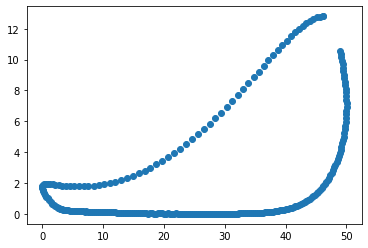

In [ ]:
import xlrd
import matplotlib.pyplot as plt

loc = ("Gait_DATA.xlsx")
wb = xlrd.open_workbook(loc)
sheet = wb.sheet_by_index(0)
n = sheet.nrows
X = []
Y = []
for i in range(1,n):
  X.append(sheet.cell_value(i,0))
  Y.append(sheet.cell_value(i,1))
plt.scatter(X,Y)

Task 4c

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def animate2R(t, q1t):  # simplest animation function very similar to matlab
  x1 = np.zeros(np.size(q1t))
  # x2 = np.zeros(np.size(q1t))
  y1 = np.zeros(np.size(q1t))
  # y2 = np.zeros(np.size(q1t))
  for i in range(np.size(q1t)):
    plt.clf()  # clear screen
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    # forward kinematics to get end points of both links
    x1[i] = l1 * np.cos(q1t[i])
    y1[i] = l1 * np.sin(q1t[i])
    # x2[i] = x1[i] + l2 * np.cos(q2t[i])
    # y2[i] = y1[i] + l2 * np.sin(q2t[i])
    plt.plot([0, x1[i]], [0, y1[i]], '-o')  # draw link1
    # plt.plot([x1[i], x2[i]], [y1[i], y2[i]], '-o')  # draw link2
    plt.pause(0.0001)
  plt.show()

def torque_calculator(l,m,theta):
  g = 9.8
  k = 10
  tau = m*g*l*np.sin(theta) - k*theta

  return tau

def odefunction(x,t):
  pass

dynamicsim(10,3,np.pi/6)